# Homework 3: Sampling
- Name: Congxin (David) Xu
- Computing ID: cx2rx

### Honor Pledge: 
I have neither given nor received aid on this assignment.

### Problem 1
(10) Suppose whether it is sunny or not in Charlottesville depends on the
weather of the last three days. Show how this can be modeled as a Markov
chain.

|   Last Three Days|   Sunny (S)|   Not Sunny (N)|
|:-                | ---        |---           |
|       SSS     |   P(SSSS)     |   P(SSSN)       |
|       NSS     |   P(NSSS)    |   P(NSSN)       |
|           SNS    |   P(SNSS)    |   P(SNSN)        |
|           SNS    |   P(SNSS)   |   P(SNSN)       |
|           NNS    |   P(NNSS)   |   P(NNSN)       |
|           NSN    |   P(NSNS)   |   P(NSNN)        |
|           SNN    |   P(SNNS)   |   P(SNNN)        |
|           NNN    |   P(NNNS)   |   P(NNNN)       |

Therefore, the probability of sunny in Charlottesville is sum all probabilities in the `Sunny (S)` column and the probability of not sunny in Charlottesville is sum all probabilities in the ` Not Sunny (N)` column.

### Problem 2
Let $X \sim N(\mu, \Sigma)$ where $\mu = (1, 1)$ and
$$
\Sigma = \begin{bmatrix}
1 & -0.5 \\ 
-0.5 & 1 
\end{bmatrix}
$$
Use numpy and scipy to implement a Gibbs sampling algorithm for this
2D Gaussian. Show three runs of you algorithm with 100 samples past
burn-in as 1D scatter plots in each of the two dimensions overlaid on the
plots of the actual marginal distributions.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\ProgramData\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# set up the means
a_mu = 0
b_mu = 0

a_sigma = 1
b_sigma = 1
a_b_cov = -0.5

joint_cov = np.vstack(((a_sigma, a_b_cov), (a_b_cov, b_sigma)))
joint_mu = np.vstack((a_mu, b_mu))

In [3]:
N = 10000

L = np.linalg.cholesky(joint_cov)
samples_from_true_distribution =  L @ np.random.randn(2, N) + joint_mu

In [4]:
def get_conditional_dist(joint_mu, joint_cov, var_index):
    '''Returns the conditional distribution given the joint distribution and which variable
    the conditional probability should use.
    Right now this only works for 2-variable joint distributions.
    
      joint_mu: joint distribution's mu
      joint_cov: joint distribution's covariance
      var_index: index of the variable in the joint distribution. Everything else will be 
        conditioned on. For example, if the joint distribution p(a, b, c) has mu [mu_a, mu_b, mu_c],
        to get p(c | a, b), use var_index = 2.
      
    returns:
      a function that can sample from the univariate conditional distribution
    '''
    assert joint_mu.shape[0] == 2, 'Sorry, this function only works for 2-dimensional joint distributions right now'
    a = joint_mu[var_index]
    b = joint_mu[~var_index]
    
    A = joint_cov[var_index, var_index]
    B = joint_cov[~var_index, ~var_index]
    C = joint_cov[var_index, ~var_index]
    
    # we're dealing with one dimension so
    B_inv = 1/B
    
    # Return a function that can sample given a value of g
    def dist(g):
        # a + C*B^{-1}(g - b)
        mu = a + C * B_inv * (g - b)
        # A - C * B^{-1} * C^T
        cov = A - B_inv * C * C
        return np.sqrt(cov) * np.random.randn(1) + mu
    
    return dist

In [5]:
def gibbs_sample(univariate_conditionals, sample_count):
    '''Does Gibbs sampling given the distribution's univariate conditionals.
    
    Returns a D x N matrix
    '''
    D = len(univariate_conditionals)
    assert D == 2, "Sorry, this only supports 2 dimensions right now"
    
    # initializes an empty matrix for the samples
    samples = np.zeros((D, sample_count))

    # initialize the first sample to some arbitrary value
    samples[:, 0] = [3, -3]
    
    for i in range(1, sample_count):
        # first set this sample equal to the previous sample
        samples[:, i] = samples[:, i - 1]
        
        # now update the dimension whose turn it is using the conditional distribution
        # pass in all dimension from the previous sample except this dimension
        d = i % D
        samples[d, i] = univariate_conditionals[d](samples[~d, i - 1])
                 
    return samples

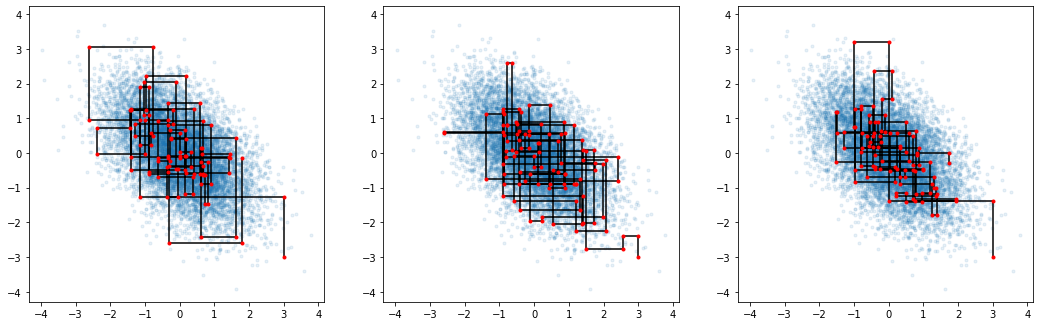

In [6]:
# 3 Runs 
fig, axs = plt.subplots(nrows = 1, ncols = 3, sharex = True, figsize = (18, 12))

for i in range(3):
    univariate_conditionals = [get_conditional_dist(joint_mu, joint_cov, d) for d in range(2)]
    samples = gibbs_sample(univariate_conditionals, sample_count=100)
    axs[i].plot(*samples_from_true_distribution, '.', alpha=0.1)
    axs[i].plot(*samples, 'k')
    axs[i].plot(*samples, '.r')
    axs[i].axis('square')


### Problem 3

(25) With the CHD data set (`CHDdata.csv`) from Homework 2 develop a
sampling based estimate for the posterior distributions of the parameters
in a main effects logistic regression model. Use all predictor variables
in the data set and standardize all of the numeric, continuous predictors
using the mean and standard deviation.

- Use Gaussian or Cauchy priors with hyperparameters appropriate for uninformed priors and show the graphical representation of your model (you should use graphviz for this).
- Show the summary table and trace plots from the sampling and briefly say what they mean for your results.
- Provide forest plots of the parameters and discuss what these results imply for the relevant predictor variables and the overall model.

In [7]:
data = pd.read_csv('CHDdata.csv')
data.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


In [8]:
# Standardize all numeric variables
tmp = data[['famhist']].astype('category')
tmp["famhist"] = tmp["famhist"].cat.codes.values

data = data.drop('famhist', axis = 1)
normalized_data=(data-data.mean())/data.std()
normalized_data = pd.concat([tmp,  
                             normalized_data.reset_index(drop=True),], 
                            axis=1)
normalized_data.head()

,famhist,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd
0,1,1.057417,1.821099,0.477894,-0.295183,-0.418017,-0.176594,3.274189,0.628654,1.372375
1,0,0.276789,-0.789382,-0.159507,0.411694,0.193134,0.670646,-0.612081,1.381617,1.372375
2,1,-0.991731,-0.774141,-0.608585,0.883374,-0.112441,0.734723,-0.540597,0.217947,-0.727086
3,1,1.545310,0.841352,0.806252,1.622382,-0.214300,1.411091,0.294742,1.039361,1.372375
4,1,-0.211103,2.169453,-0.598928,0.305020,0.702427,-0.012842,1.645991,0.423301,1.372375


In [9]:
# with pm.Model() as manual_logistic_model:
#     Y = data["income_more_50K"]
#     # intercept
#     α = pm.Normal('α', mu=0, sd=100) 
    
#     # coefficients
#     β1 = pm.Normal('β1', mu=0, sd=100) 
#     β2 = pm.Normal('β2', mu=0, sd=100)  
    
#     # Equation
#     μ = α + pm.math.dot(data["age"], β1)+pm.math.dot(data["educ"],β2) 
    
#     θ = pm.Deterministic('θ',  pm.invlogit(μ))
    
#     Yl = pm.Bernoulli('Yl', p=θ, observed=Y) 
#     map_estimate = pm.find_MAP()
#     print(map_estimate)

In [10]:
practitioner_idx = normalized_data.famhist.astype('category').cat.codes.values
normalized_data.columns

Index(['famhist', 'sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity',
       'alcohol', 'age', 'chd'],
      dtype='object')

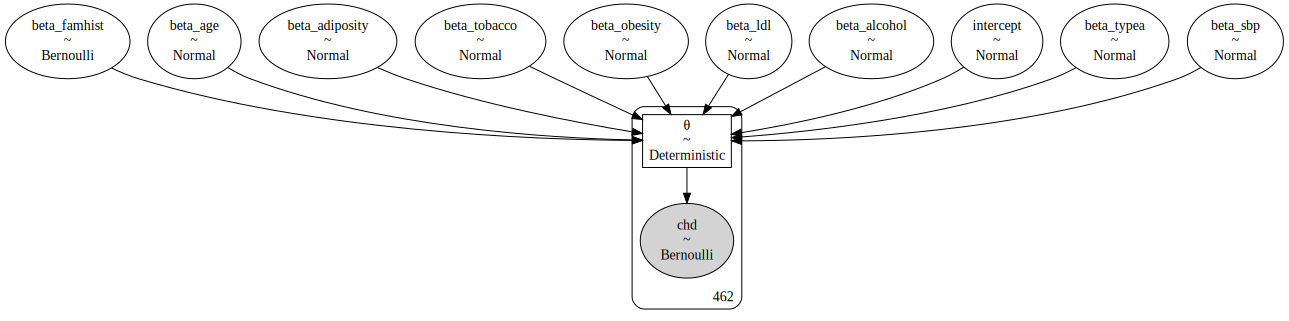

In [11]:
with pm.Model() as manual_logistic_model:
    
    # coefficients
    intercept = pm.Normal('intercept', mu=0, sd=100) 
    beta_famhist = pm.Bernoulli('beta_famhist', p = 0.5)
    beta_sbp = pm.Normal('beta_sbp', mu=0, sd=100) 
    beta_tobacco = pm.Normal('beta_tobacco', mu=0, sd=100)
    beta_ldl = pm.Normal('beta_ldl', mu=0, sd=100)
    beta_adiposity = pm.Normal('beta_adiposity', mu=0, sd=100)
    beta_typea = pm.Normal('beta_typea', mu=0, sd=100)
    beta_obesity = pm.Normal('beta_obesity', mu=0, sd=100)
    beta_alcohol = pm.Normal('beta_alcohol', mu=0, sd=100)
    beta_age = pm.Normal('beta_age', mu=0, sd=100)

    
    μ = intercept + \
        pm.math.dot(normalized_data["famhist"], beta_famhist) + \
        pm.math.dot(normalized_data["sbp"], beta_sbp) + \
        pm.math.dot(normalized_data["tobacco"], beta_tobacco) + \
        pm.math.dot(normalized_data["ldl"], beta_ldl) + \
        pm.math.dot(normalized_data["adiposity"], beta_adiposity) + \
        pm.math.dot(normalized_data["typea"], beta_typea) + \
        pm.math.dot(normalized_data["obesity"], beta_obesity) + \
        pm.math.dot(normalized_data["alcohol"], beta_alcohol) + \
        pm.math.dot(normalized_data["age"], beta_age)
    
    θ = pm.Deterministic('θ', pm.invlogit(μ))
        
    y = pm.Bernoulli('chd',
                     θ[practitioner_idx], 
                     observed=normalized_data.chd)    

pm.model_to_graphviz(manual_logistic_model)

In [17]:
with pm.Model() as logistic_model:
    Y = normalized_data['chd']
    pm.glm.GLM.from_formula('Y ~ famhist+sbp+tobacco+ldl+adiposity+typea+obesity+alcohol+age',
                            data = normalized_data, family = pm.glm.families.Binomial())
    trace = pm.sample(1000, tune = 1000, init = 'adapt_diag', cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [age, alcohol, obesity, typea, adiposity, ldl, tobacco, sbp, famhist, Intercept]


ValueError: Not enough samples to build a trace.

### Problem 4
(20) With the data set `bangladesh.csv` develop a pooled, a no-pooled, and
a hierarchical model for all districts to predict `contraception usage`. Use
only `district` and `age.centered` as predictor variables. Plot each of these
predictions with age.centered on the x-axis and the expected proportion
of women using contraception on the y-Axis with overlaid plots for the
districts. Briefly explain these results.

In [18]:
data = pd.read_csv('bangladesh.csv')
data.head()

,woman,district,use.contraception,living.children,age.centered,urban
0,1,1,0,4,18.4400,1
1,2,1,0,1,-5.5599,1
2,3,1,0,3,1.4400,1
3,4,1,0,4,8.4400,1
4,5,1,0,1,-13.5590,1


### Problem 5
(25) For the CHD data in problem 3, develop two other models with fewer
predictor variables and/or with a nonlinear transformation of one of the
the predictor variables.

- Use WAIC to recommend which of these models to use.
- Use WAIC to produce a Bayesian model average result. Show the kernel density plots for the sample posterior predictions of each of the models and the Bayesian model average.
- (5 points extra credit) Show the overlaid plots of the predictions for the data points in the `CHDdata.csv` file with age on the x-axis and the predicted probability on the y-axis. Overlay these results for each model and for the Bayesian model average of the models.